### ESE 527 Group Project: Anime Recommendation System Design

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from scipy.sparse import csr_matrix

random.seed(0)

### Data Preprocessing

#### Read data

In [3]:
# In this Project, we're using the "Anime Recommendation Database 2020" from Kaggle
# The referral link is the following:
# https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=watching_status.csv

# Read the anime information data
anime = pd.read_csv('anime.csv')
# Read the rating data
rating = pd.read_csv('animelist.csv')


#### Show data

In [3]:
print(f"anime shape: {anime.shape}\n")
anime.head()

anime shape: (17562, 35)



,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
print(f"rating shape: {rating.shape}\n")
rating.head()

rating shape: (109224747, 5)



,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


#### Data cleaning 

In [4]:
# Drop the record in "Anime" and "Rating" whose episodes is "Unknown"
unknown_episode= anime['MAL_ID'][anime['Episodes']=='Unknown']
filtered_rating = rating [~rating['anime_id'].isin(unknown_episode)].reset_index(drop=True)
filtered_anime= anime[~anime['MAL_ID'].isin(unknown_episode)].reset_index(drop=True)
# Change the dtype of the "Episodes" in filtered_anime to int
filtered_anime["Episodes"]=filtered_anime["Episodes"].astype(int)

In [5]:
# Generate a dictoinary to accommandate the number of episode with respect to each Anime 
ep_dict=filtered_anime.set_index('MAL_ID')['Episodes'].to_dict()
print(ep_dict )

{1: 26, 5: 1, 6: 26, 7: 26, 8: 52, 15: 145, 16: 24, 17: 52, 18: 24, 19: 74, 20: 220, 22: 178, 23: 12, 24: 26, 25: 24, 26: 22, 27: 24, 28: 69, 29: 26, 30: 26, 31: 1, 32: 1, 33: 25, 43: 1, 44: 4, 45: 94, 46: 1, 47: 1, 48: 26, 49: 5, 50: 24, 51: 3, 52: 26, 53: 24, 54: 1, 55: 26, 56: 13, 57: 26, 58: 26, 59: 26, 60: 24, 61: 26, 62: 26, 63: 12, 64: 12, 65: 12, 66: 26, 67: 24, 68: 23, 69: 25, 71: 24, 72: 12, 73: 13, 74: 26, 75: 25, 76: 13, 77: 13, 79: 24, 80: 43, 81: 12, 82: 6, 83: 1, 84: 13, 85: 50, 86: 47, 87: 1, 88: 1, 89: 51, 90: 49, 91: 3, 92: 39, 93: 50, 94: 50, 95: 50, 96: 49, 97: 26, 98: 26, 99: 26, 100: 13, 101: 12, 102: 26, 103: 74, 104: 24, 105: 13, 106: 51, 107: 13, 108: 3, 109: 24, 110: 52, 111: 52, 112: 8, 113: 26, 114: 26, 115: 13, 116: 26, 117: 7, 118: 4, 119: 13, 120: 26, 121: 51, 122: 52, 123: 52, 124: 4, 125: 13, 126: 13, 127: 24, 128: 6, 129: 50, 130: 25, 131: 26, 132: 49, 133: 12, 134: 13, 135: 75, 136: 62, 137: 8, 138: 8, 139: 14, 141: 12, 142: 44, 143: 12, 144: 13, 145:

In [ ]:
# Normalize the "watched_episodes" column for the rating dataset.
filtered_rating['watched_episode_normalized'] = filtered_rating.apply(lambda row: row['watched_episodes'] / ep_dict[row['anime_id']], axis=1)

In [12]:
# Show the normalized filtered_rating
normalized_rating=filtered_rating.drop(columns='watched_episodes')
print(normalized_rating.shape)
normalized_rating.head()

(108240894, 5)


,user_id,anime_id,rating,watching_status,watched_episode_normalized
0,0,67,9,1,0.041667
1,0,6702,7,1,0.022857
2,0,242,10,1,0.307692
3,0,4898,0,1,0.041667
4,0,24,9,1,0.192308


In [13]:
# Remove the record that user didn't give a rating (rating=0)
useful_rating=normalized_rating[normalized_rating['rating']!= 0 ]


# Remove the record that user's watching status is "Dropped" and "Plan to watch" 

# Keep the record with user is currently watching 
rating_1 = useful_rating[(useful_rating['watching_status'] == 1)]
# Keep the record with the user has completed watching
rating_2 = useful_rating[(useful_rating['watching_status'] == 2)]
# Keep the record of the user that is on hold 
rating_3 = useful_rating[(useful_rating['watching_status'] == 3)]

                                


In [40]:
rating_3

,user_id,anime_id,rating,watching_status,watched_episode_normalized
50,0,269,9,3,0.174863
1170,4,2704,7,3,0.000000
1735,6,1974,6,3,0.235294
1737,6,7062,8,3,0.166667
2466,11,9062,7,3,1.000000
...,...,...,...,...,...
108240633,353402,16,7,3,0.041667
108240634,353402,1838,7,3,0.500000
108240635,353402,1198,6,3,0.083333
108240740,353403,16512,7,3,0.615385


#### Outlier Detection

##### KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

def KNN_Outlier_Detection(input_df, n_neighbors):
    scaler = StandardScaler()
    inliers_result = pd.DataFrame()
    outliers_result = pd.DataFrame()

    for anime_id, group in input_df.groupby('anime_id'):
        # Prepare the features for KNN
        features = group[['rating', 'watched_episode_normalized']]
        
        # Scale the features
        features_scaled = scaler.fit_transform(features)
        
        # Apply NearestNeighbors
        neighbors = NearestNeighbors(n_neighbors=n_neighbors)
        neighbors_fit = neighbors.fit(features_scaled)
        distances, indices = neighbors_fit.kneighbors(features_scaled)
        
        # Find the distance threshold as the mean distance to the nth neighbor
        distance_threshold = distances[:, n_neighbors - 1].mean()
        
        # Find outliers: points with a distance greater than the threshold
        outlier_indices = distances[:, n_neighbors - 1] > distance_threshold
        group['outlier'] = outlier_indices
        
        # Separate inliers and outliers
        inliers = group[~group['outlier']]
        outliers = group[group['outlier']]
        
        # Append to the respective DataFrames
        inliers_result = pd.concat([inliers_result, inliers])
        outliers_result = pd.concat([outliers_result, outliers])

    # Optionally, you might want to remove the 'outlier' column
    # inliers_result = inliers_result.drop(columns=['outlier'])
    # outliers_result = outliers_result.drop(columns=['outlier'])
    
    return inliers_result, outliers_result

# Replace 'rating_1' and 'rating_3' with the actual DataFrame names you have
# Inliers and Outliers for rating_1 using KNN
inlier_1_knn, outlier_1_knn = KNN_Outlier_Detection(rating_1, n_neighbors=5)

# Inliers and Outliers for rating_3 using KNN
inlier_3_knn, outlier_3_knn = KNN_Outlier_Detection(rating_3, n_neighbors=5)

def plot_inliers_outliers_knn(inliers, outliers):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plot for normalized_episode
    ax[0].scatter(outliers['anime_id'], outliers['watched_episode_normalized'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[0].scatter(inliers['anime_id'], inliers['watched_episode_normalized'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[0].set_xlabel('Anime ID')
    ax[0].set_ylabel('Normalized Episode')
    ax[0].set_title('KNN Normalized Episode by Anime ID')
    ax[0].legend()

    # Plot for rating
    ax[1].scatter(outliers['anime_id'], outliers['rating'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[1].scatter(inliers['anime_id'], inliers['rating'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[1].set_xlabel('Anime ID')
    ax[1].set_ylabel('Rating')
    ax[1].set_title('KNN Rating by Anime ID')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize the results
plot_inliers_outliers_knn(inlier_1_knn, outlier_1_knn)


##### K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def KMeans_Outlier_Detection(input_df, num_clusters):
    scaler = StandardScaler()
    inliers_result = pd.DataFrame()
    outliers_result = pd.DataFrame()

    for anime_id, group in input_df.groupby('anime_id'):
        # Prepare the features for KMeans
        features = group[['rating', 'watched_episode_normalized']]
        
        # Scale the features
        features_scaled = scaler.fit_transform(features)
        
        # Apply KMeans
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        group['cluster'] = kmeans.fit_predict(features_scaled)
        
        # Calculate the distance from each point to its cluster center
        centers = kmeans.cluster_centers_
        distance = np.sqrt(((features_scaled - centers[group['cluster']]) ** 2).sum(axis=1))
        
        # Determine a threshold for defining an outlier
        distance_threshold = np.percentile(distance, 95)  # setting threshold at the 95th percentile
        
        # Identify inliers and outliers
        group['outlier'] = distance > distance_threshold
        
        # Separate inliers and outliers
        inliers = group[~group['outlier']]
        outliers = group[group['outlier']]
        
        # Append to the respective DataFrames
        inliers_result = pd.concat([inliers_result, inliers])
        outliers_result = pd.concat([outliers_result, outliers])

    # Optionally, you might want to remove the 'cluster' and 'outlier' columns
    # inliers_result = inliers_result.drop(columns=['cluster', 'outlier'])
    # outliers_result = outliers_result.drop(columns=['cluster', 'outlier'])
    
    return inliers_result, outliers_result

# Replace 'rating_1' with the actual DataFrame name you have
# Inliers and Outliers for rating_1 using KMeans
inlier_1_km, outlier_1_km = KMeans_Outlier_Detection(rating_1, num_clusters=5)

# Replace 'rating_3' with the actual DataFrame name you have
# Inliers and Outliers for rating_3 using KMeans
inlier_3_km, outlier_3_km = KMeans_Outlier_Detection(rating_3, num_clusters=5)

def plot_inliers_outliers_km(inliers, outliers):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plot for normalized_episode
    ax[0].scatter(outliers['anime_id'], outliers['watched_episode_normalized'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[0].scatter(inliers['anime_id'], inliers['watched_episode_normalized'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[0].set_xlabel('Anime ID')
    ax[0].set_ylabel('Normalized Episode')
    ax[0].set_title('KMeans Normalized Episode by Anime ID')
    ax[0].legend()

    # Plot for rating
    ax[1].scatter(outliers['anime_id'], outliers['rating'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[1].scatter(inliers['anime_id'], inliers['rating'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[1].set_xlabel('Anime ID')
    ax[1].set_ylabel('Rating')
    ax[1].set_title('KMeans Rating by Anime ID')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize the results for rating_1
plot_inliers_outliers_km(inlier_1_km, outlier_1_km)

# To visualize results for rating_3, call:
# plot_inliers_outliers_km(inlier_3_km, outlier_3_km)


##### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

def IsolationForest_Outlier_Detection(input_df, contamination_factor):
    scaler = StandardScaler()
    inliers_result = pd.DataFrame()
    outliers_result = pd.DataFrame()

    # Scaling the features
    features = input_df[['rating', 'watched_episode_normalized']]
    features_scaled = scaler.fit_transform(features)

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=contamination_factor, random_state=42)
    anomalies = iso_forest.fit_predict(features_scaled)

    # Assign the results to the input DataFrame
    input_df['anomaly'] = anomalies
    input_df['anomaly'] = input_df['anomaly'].apply(lambda x: 'outlier' if x == -1 else 'inlier')

    # Separate inliers and outliers
    inliers_result = input_df[input_df['anomaly'] == 'inlier']
    outliers_result = input_df[input_df['anomaly'] == 'outlier']

    return inliers_result, outliers_result

# Replace 'data' with your actual DataFrame name
# Inliers and Outliers using Isolation Forest
inliers, outliers = IsolationForest_Outlier_Detection(data, contamination_factor=0.01)

def plot_inliers_outliers_if(inliers, outliers):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plot for watched_episode_normalized
    ax[0].scatter(inliers['anime_id'], inliers['watched_episode_normalized'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[0].scatter(outliers['anime_id'], outliers['watched_episode_normalized'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[0].set_xlabel('Anime ID')
    ax[0].set_ylabel('Normalized Episode')
    ax[0].set_title('Watched Episode Normalized by Anime ID')
    ax[0].legend()

    # Plot for rating
    ax[1].scatter(inliers['anime_id'], inliers['rating'], color='blue', label='Inliers', alpha=0.5, s=10)
    ax[1].scatter(outliers['anime_id'], outliers['rating'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[1].set_xlabel('Anime ID')
    ax[1].set_ylabel('Rating')
    ax[1].set_title('Rating by Anime ID')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize the results
plot_inliers_outliers_if(inliers, outliers)


##### DBSCAN

In [21]:
# In this project, we use DBScan for outlier detection 

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def DB_Scan (input_df, eps, n):
    scaler = StandardScaler()
    inliers_result = pd.DataFrame()
    outliers_result = pd.DataFrame()

    for anime_id, group in input_df.groupby('anime_id'):
        # Prepare the features for DBSCAN
        features = group[['rating', 'watched_episode_normalized']]
        
        # Scale the features
        features_scaled = scaler.fit_transform(features)
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=n)
        cluster_labels = dbscan.fit_predict(features_scaled)
        
        # Assign the cluster labels to the group
        group['cluster'] = cluster_labels
        
        # Separate inliers and outliers
        inliers = group[group['cluster'] != -1]
        outliers = group[group['cluster'] == -1]
        
        # Append to the respective DataFrames
        inliers_result = pd.concat([inliers_result, inliers])
        outliers_result = pd.concat([outliers_result, outliers])

    # Optionally, you might want to remove the 'cluster' column
    #inliers_result = inliers_result.drop(columns=['cluster'])
    #outliers_result = outliers_result.drop(columns=['cluster'])
    
    return inliers_result, outliers_result

# Example of how to use the function
# watch_1, watch_2, and watch_3 are your separated DataFrames based on watching status.
# Adjust 'eps' and 'n' based on your dataset and needs.
# inliers, outliers = apply_dbscan_to_watches(watch_1, eps=0.5, n=5)


In [23]:
#Inliers and Outliers for rating_1
inlier_1 , outlier_1= DB_Scan (rating_1, eps=0.5, n=5)


In [28]:
#Inliers and Outliers for rating_3
inlier_3 , outlier_3= DB_Scan (rating_3, eps=0.5, n=5)

In [39]:
inlier_3

,user_id,anime_id,rating,watching_status,watched_episode_normalized,cluster
37383,145,1,7,3,0.192308,0
59455,219,1,7,3,0.076923,0
59878,221,1,10,3,0.500000,1
102679,349,1,7,3,0.384615,0
105849,362,1,8,3,0.000000,2
...,...,...,...,...,...,...
106712227,348382,44248,9,3,0.250000,5
107167712,349909,44248,6,3,0.250000,4
107172271,349925,44248,7,3,0.250000,3
107580706,351195,44248,7,3,0.250000,3


In [45]:
def plot_inliers_outliers(inliers, outliers):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plot for normalized_episode
    ax[0].scatter(outliers['anime_id'], outliers['watched_episode_normalized'], color='red', label='Outliers', alpha=0.5, s=10)
   
    ax[0].scatter(inliers['anime_id'], inliers['watched_episode_normalized'], color='blue', label='Inliers', alpha=0.5, s=10)
    
    ax[0].set_xlabel('Anime ID')
    ax[0].set_ylabel('Normalized Episode')
    ax[0].set_title('Normalized Episode by Anime ID')
    ax[0].legend()

    # Plot for rating
    ax[1].scatter(outliers['anime_id'], outliers['rating'], color='red', label='Outliers', alpha=0.5, s=10)
    ax[1].scatter(inliers['anime_id'], inliers['rating'], color='blue', label='Inliers', alpha=0.5, s=10)
    
    ax[1].set_xlabel('Anime ID')
    ax[1].set_ylabel('Rating')
    ax[1].set_title('Rating by Anime ID')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

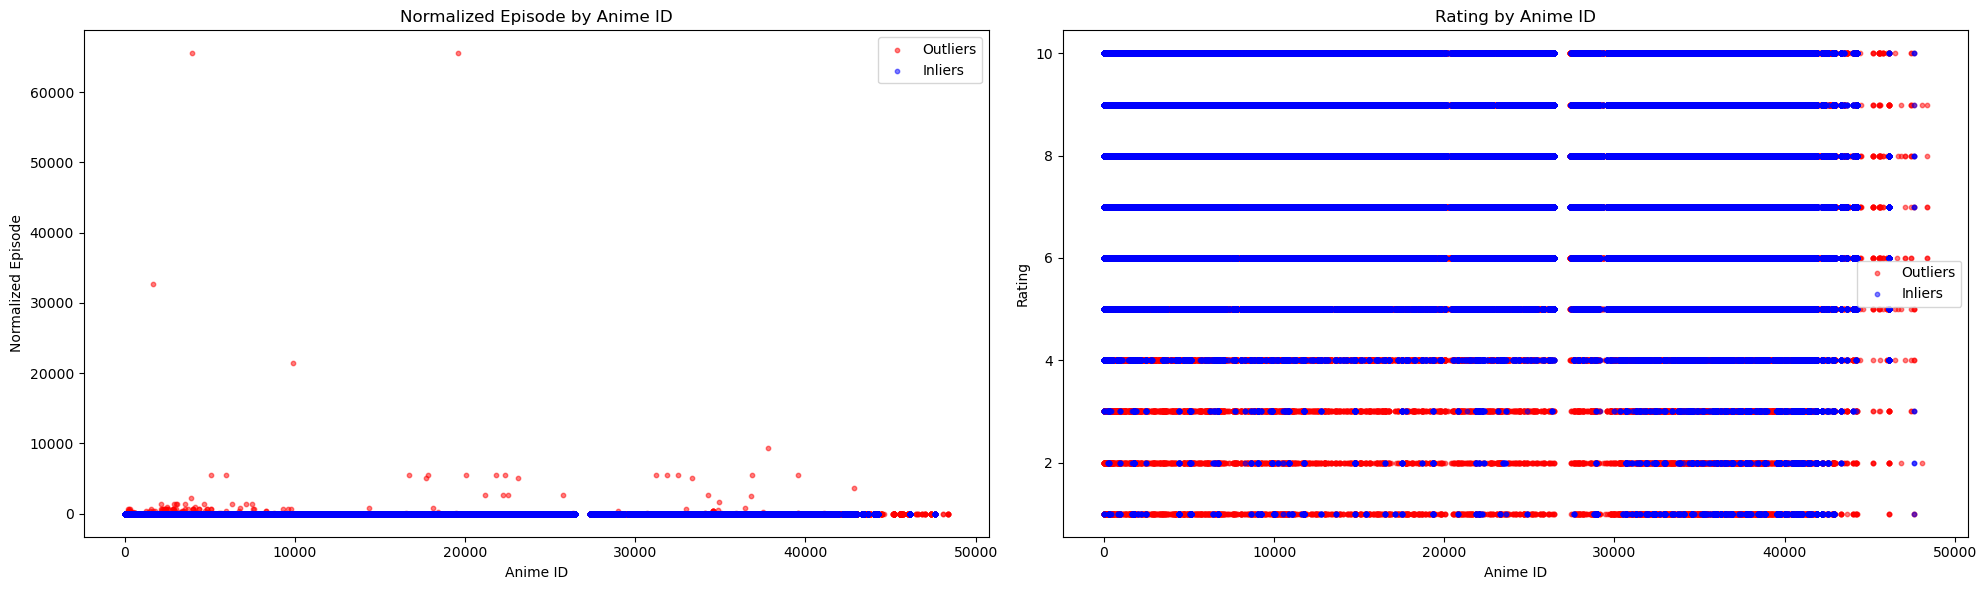

In [46]:
 plot_inliers_outliers(inlier_1,outlier_1)

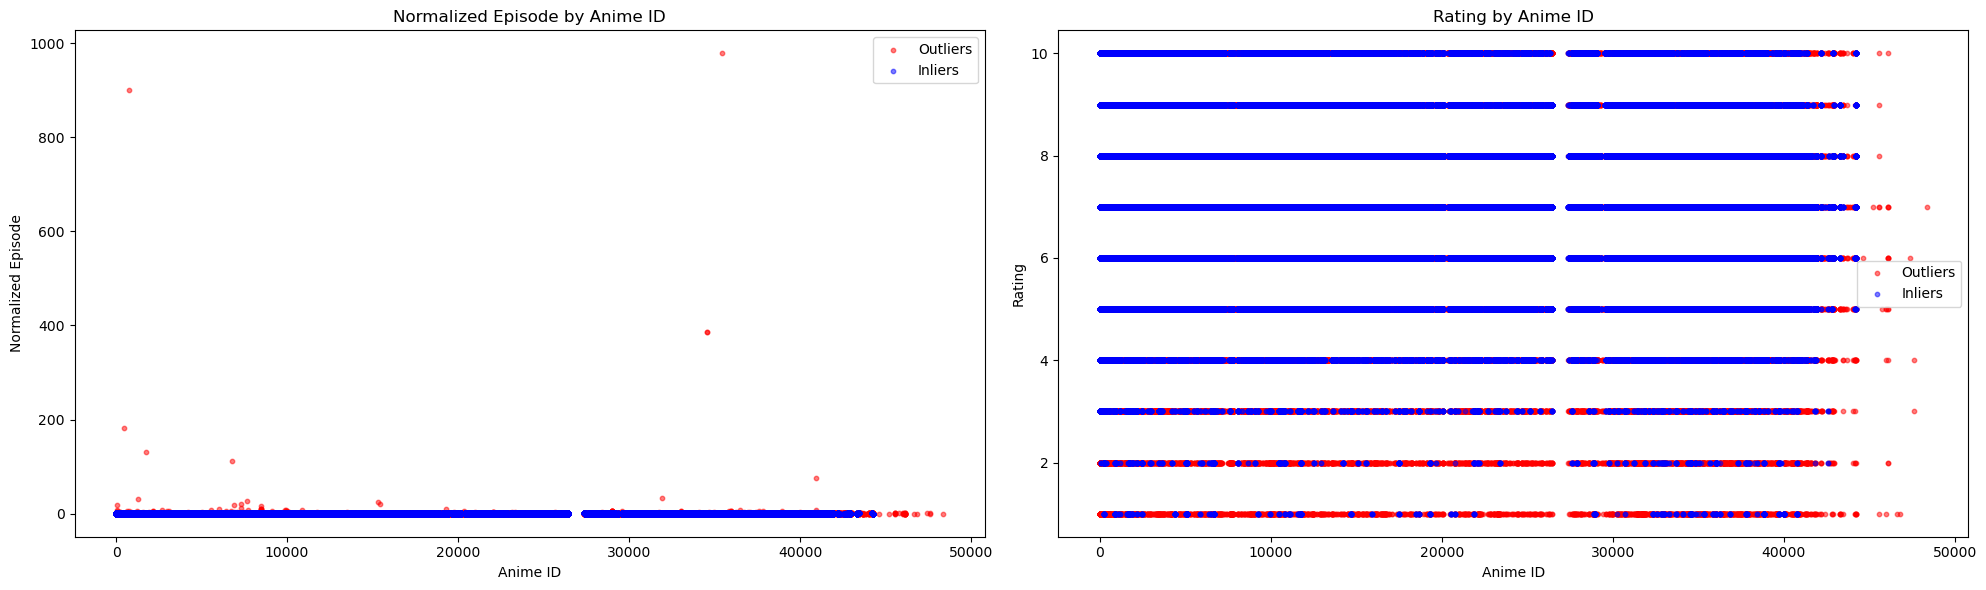

In [47]:
 plot_inliers_outliers(inlier_3,outlier_3)

In [8]:
print(f"user_item_matrix shape: {user_item_matrix.shape}\n")
user_item_matrix.head()

user_item_matrix shape: (29131, 9685)



anime_id,1,5,6,7,8,15,16,17,18,19,...,44087,44236,45574,45598,45753,46491,47398,47402,47616,48456
user_id,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,8.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### KNN